In [2]:
import pickle
import numpy as np

In [3]:
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [4]:
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [5]:
type(test_data)

list

In [6]:
type(train_data)

list

In [7]:
len(test_data)

1000

In [8]:
len(train_data)

10000

In [9]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [10]:
all_data = test_data + train_data

In [11]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [12]:
vocab.add('yes')
vocab.add('no')

In [13]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [14]:
vocab_len = len(vocab) + 1

In [15]:
max_story_len = max([len(data[0]) for data in all_data])

In [18]:
max_question_len =  max([len(data[1]) for data in all_data])

In [20]:
from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

In [22]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [23]:
tokenizer.word_index

{'put': 1,
 'office': 2,
 'garden': 3,
 '?': 4,
 'the': 5,
 'apple': 6,
 'yes': 7,
 'no': 8,
 'football': 9,
 'journeyed': 10,
 'picked': 11,
 'mary': 12,
 'there': 13,
 'grabbed': 14,
 '.': 15,
 'in': 16,
 'took': 17,
 'bathroom': 18,
 'travelled': 19,
 'john': 20,
 'dropped': 21,
 'back': 22,
 'left': 23,
 'hallway': 24,
 'got': 25,
 'is': 26,
 'went': 27,
 'to': 28,
 'discarded': 29,
 'up': 30,
 'sandra': 31,
 'down': 32,
 'kitchen': 33,
 'milk': 34,
 'bedroom': 35,
 'moved': 36,
 'daniel': 37}

In [24]:
train_story_text = []
train_question_text = []
train_answers = []

In [25]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [28]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len = max_question_len):
    
    #Stories
    X=[]
    #Questions
    Xq=[]
    #Correct Answer
    Y=[]
    
    for story,query,answer in data:
        
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen= max_question_len), np.array(Y))

In [29]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

# Keras Deep Learning Portion

In [30]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [31]:
input_sequence = Input((max_story_len, ))
question = Input((max_question_len, ))

In [32]:
vocab_size = len(vocab) + 1

In [33]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))


Instructions for updating:
Colocations handled automatically by placer.


In [34]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))


In [35]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

#OUTPUT
#(samples, query_maxlen, embedding_dim)

In [37]:
#Encoded <- Encoder(input)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [38]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [39]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [40]:
answer = concatenate([response, question_encoded])

In [41]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [42]:
answer = LSTM(32)(answer)

In [43]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) #Output (samples, vocab_size)

In [44]:
answer = Activation('softmax')(answer)

In [45]:
model = Model([input_sequence, question], answer)

In [46]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [49]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 3s 283us/step - loss: 0.6958 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 2/100
10000/10000 [==============================] - 3s 280us/step - loss: 0.6948 - accuracy: 0.5056 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 3/100
10000/10000 [==============================] - 3s 277us/step - loss: 0.6949 - accuracy: 0.5012 - val_loss: 0.6934 - val_accuracy: 0.4910
Epoch 4/100
10000/10000 [==============================] - 3s 280us/step - loss: 0.6941 - accuracy: 0.5084 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 5/100
10000/10000 [==============================] - 3s 283us/step - loss: 0.6948 - accuracy: 0.5009 - val_loss: 0.6963 - val_accuracy: 0.4970
Epoch 6/100
10000/10000 [==============================] - 3s 282us/step - loss: 0.6941 - accuracy: 0.5041 - val_loss: 0.6942 - val_accuracy: 0.4570
Epoch 7/100
10000/10000 [==============================] 

In [76]:
filename = 'chatbot_100_epochs.h5'
model.save(filename)

pickle.dump(tokenizer, open('bot_tokenizer', 'wb'))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


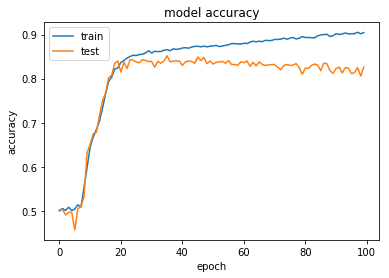

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
model.load_weights('chatbot_100_epochs.h5')

In [54]:
pred_results = model.predict(([inputs_test,queries_test]))

In [55]:
#Returns the index of the word with the highest probability
val_max = np.argmax(pred_results[0])

In [56]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [61]:
' '.join(test_data[0][0])

'Mary got the milk there . John moved to the bedroom .'

In [62]:
' '.join(test_data[0][1])

'Is John in the kitchen ?'

In [57]:
#Model's prediction for question index 0
k

'no'

In [63]:
#How sure the model is 
pred_results[0][val_max]

0.9999459

# Create Your Own Question
Keep in mind, you can only use words from the existing vocab

In [64]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

In [65]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [66]:
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [67]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [68]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [69]:
pred_results = model.predict(([my_story, my_ques]))

In [70]:
val_max = np.argmax(pred_results[0])

In [71]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [73]:
k

'yes'

In [74]:
pred_results[0][val_max]

0.98735833